In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2D, Concatenate, BatchNormalization, DepthwiseConv2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.layers import Lambda, Reshape, Layer, Activation, add
from tensorflow.keras import layers
from math import ceil
import numpy as np

In [2]:
class GhostModule(Layer):
  def __init__(self, out, ratio, dwkernel):
    super(GhostModule, self).__init__()
    self.ratio = ratio
    self.out = out
    self.conv_out_channel = ceil(self.out * 1.0 / ratio)    
    self.conv = Conv2D(int(self.conv_out_channel), (3, 3),
                        strides=(1, 1), padding='same', activation='relu')
    self.depthconv = DepthwiseConv2D(dwkernel, 1, padding='same',
                        depth_multiplier=ratio-1, activation='relu')
    self.concat = Concatenate()
    self.BN = BatchNormalization()

  def call(self, inputs):
    x = self.conv(inputs)
    if self.ratio == 1:
      return x
    dw = self.depthconv(x)
    dw = dw[:, :, :, :int(self.out - self.conv_out_channel)]
    output = self.BN(self.concat([x, dw]))
    return output

In [3]:
class GhostVGG16(Model):
  def __init__(self):
    super(GhostVGG16, self).__init__()
    self.outs = [64, 64, 128, 128, 256, 256, 256, 512, 512, 512, 512, 512, 512]       
    self.ratio = [2]*13
    self.dwkernek = [3]*13
    self.flatten = Flatten()
    self.MaxPooling = MaxPooling2D((2,2))
    self.dense1 = Dense(4096, activation='relu')
    self.dense2 = Dense(4096, activation='relu')
    self.dense3 = Dense(10, activation='softmax')    
    self.dropout = Dropout(0.5)
    for i, args in enumerate(zip(self.outs, self.ratio, self.dwkernek)):
      setattr(self, f"Gmodule{i+1}", GhostModule(*args)) 
    
  def call(self, inputs):        
    #2 x 64    
    #x = self.G_Module0(inputs)
    x = getattr(self, f"Gmodule1")(inputs) 
    x = getattr(self, f"Gmodule2")(x)
    x = self.MaxPooling(x)
    #2 x 128
    x = getattr(self, f"Gmodule3")(x) 
    x = getattr(self, f"Gmodule4")(x)
    x = self.MaxPooling(x)
    #3 x 256
    x = getattr(self, f"Gmodule5")(x) 
    x = getattr(self, f"Gmodule6")(x)    
    x = getattr(self, f"Gmodule7")(x) 
    x = self.MaxPooling(x)
    #3 x 512
    x = getattr(self, f"Gmodule8")(x) 
    x = getattr(self, f"Gmodule9")(x)
    x = getattr(self, f"Gmodule10")(x)
    x = self.MaxPooling(x)
    #3 x 512
    x = getattr(self, f"Gmodule11")(x)  
    x = getattr(self, f"Gmodule12")(x)
    x = getattr(self, f"Gmodule13")(x)
    x = self.MaxPooling(x)  
    #flat  
    flat = self.flatten(x)
    x = self.dense1(flat)
    x = self.dropout(x)
    x = self.dense2(x)
    x = self.dropout(x)
    #dense 10
    output = self.dense3(x)
    return output

In [4]:
def scheduler(epoch):
  learning_rate = 0.01
  if epoch < epoch_num * 0.4:
    return learning_rate
  if epoch < epoch_num * 0.8:
    return learning_rate * 0.1
  return learning_rate * 0.01

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [6]:
x_train = tf.cast(x_train, tf.float32)
x_test = tf.cast(x_test, tf.float32)
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [7]:
IMAGE_SIZE = 32
batch_size = 64
epoch_num = 50
AUTO = tf.data.AUTOTUNE

In [8]:
simple_aug = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ]
)

# Now, map the augmentation pipeline to our training dataset
train_ds_simple = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(64 * 100)
    .batch(64)
    .map(lambda x, y: (simple_aug(x), y), num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

test_ds_simple = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .shuffle(64 * 100)
    .batch(64)
    .map(lambda x, y: (simple_aug(x), y), num_parallel_calls=AUTO)
    .prefetch(AUTO)
) 

In [9]:
change_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
sgd = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [10]:
model = GhostVGG16()
model.build(input_shape = (1, 32, 32, 3))
model.summary()
checkpoint = tf.train.Checkpoint(myModel=model)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
history = model.fit(train_ds_simple,
          batch_size=batch_size,
          epochs=epoch_num,
          callbacks=[change_lr],
          validation_data=test_ds_simple)

Model: "ghost_vg_g16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            multiple                  0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  2101248   
_________________________________________________________________
dense_1 (Dense)              multiple                  16781312  
_________________________________________________________________
dense_2 (Dense)              multiple                  40970     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
ghost_module (GhostModule)   multiple                 

In [11]:
model.metrics_names

['loss', 'accuracy']

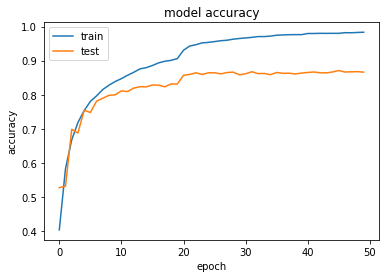

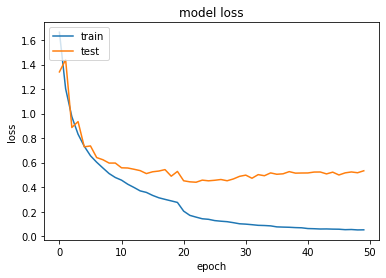

In [12]:
# summarize history for accuracy
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
checkpoint.save('/content/drive/MyDrive/Colab Notebooks/2021/paper/gostnet/weight/Gost-VGG16-r2/model.ckpt')

'/content/drive/MyDrive/Colab Notebooks/2021/paper/gostnet/weight/Gost-VGG16-r2/model.ckpt-1'